## Analyzing warbler data from Alcaide et al 2014

We want to be able to recapitulate the ring-like migration surface of the greenish warbler species in Asia, but also detect long-range migration events from the SpaceMix paper. 

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from random import choices
import scipy as sp
import networkx as nx
from sklearn.metrics.pairwise import haversine_distances

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import plotly.express as px

# feems
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats, run_cv_joint
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range, get_best_lre
from feems.joint_ver import FEEMSmix_SpatialGraph, FEEMSmix_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

In [9]:
os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/warblers/data")
coord = np.loadtxt("warblr.coord")  # sample coordinates
outer = np.loadtxt("warblr.outer")  # outer coordinates
grid_path = "/Users/vivaswatshastry/src/feems/feems/data/grid_50.shp"  # path to discrete global grid

# # graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=3,
                                             outer=outer)
genotypes = np.loadtxt('genotypes_ESM13.csv',skiprows=0,delimiter=' ')

In [22]:
# obj.extract_outliers(0.01)


Using a significance threhsold of 0.01:

1 outlier deme pairs found
 source  dest. source (lat., long.) dest. (lat., long.)     pval
   1526    699     (38.289, 45.333)    (39.535, 43.703) 0.007382

Putative destination demes (and # of times the deme appears as an outlier) experiencing admixture:
699    1
Name: dest., dtype: int64


,source,dest.,"source (lat., long.)","dest. (lat., long.)",pval,raw diff.,"# of samples (source, dest.)",Fst
0,1526,699,"(38.289, 45.333)","(39.535, 43.703)",0.007382,-0.53173,"(6, 3)",0.230826


/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, *

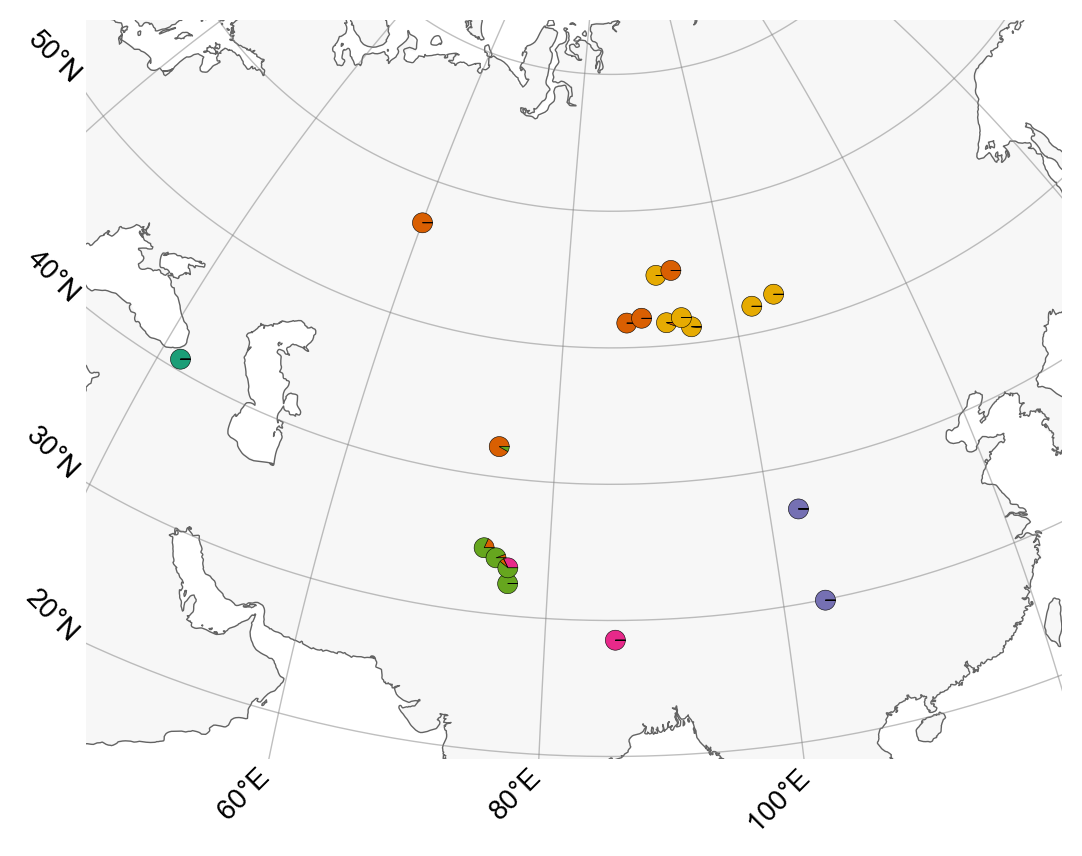

In [38]:
## testing to see how outer & buffer play a role in creating a polygon grid
# warblr_graph = FEEMSmix_SpatialGraph(genotypes, coord, grid, edges)
# warblr_graph.fit(lamb=0.1,optimize_q='n-dim',lamb_q=1.)
# obj = FEEMSmix_Objective(warblr_graph); 
# projection = ccrs.AzimuthalEquidistant(central_longitude=85.5, central_latitude=42.54)  
# obj.extract_outliers(0.01) 
# obj.Lpinv = np.linalg.pinv(warblr_graph.L.todense())
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, warblr_graph, obj, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1,
        cbar_font_size=8)
v.ax.set_extent([45,120,19,70], crs=ccrs.PlateCarree())
v.draw_map(); #v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
for i in obj.perm_idx[:warblr_graph.n_observed_nodes]:
        draw_admix_pie(Q_k6[warblr_graph.nodes[i]['sample_idx'][0], :], v.grid[i, 0], v.grid[i, 1], colors_k6, radius=0.25, ax=ax)
# v.draw_arrow([(699,1526)],0.19)
# for i in range(warblr_graph.n_observed_nodes):
#     ip = np.where(obj.perm_idx==i)[0][0]
#     if ip<warblr_graph.n_observed_nodes:
#         v.ax.plot(v.grid[i,0], v.grid[i,1], 'ro', alpha=0.5, markersize=warblr_graph.q[ip]/50)
#     else:
#         R1 = np.array(-2*obj.Lpinv[:warblr_graph.n_observed_nodes,ip].T + np.diag(obj.Linv) + obj.Lpinv[ip,ip])
#         proxs = np.argsort([nx.shortest_path_length(warblr_graph,source=ip,target=d) for d in set(obj.perm_idx[:warblr_graph.n_observed_nodes])-set([ip])])[:1]
#         # qprox = np.dot(1/sp_graph.q[proxs], (1/R1[0,proxs].T)/np.sum(1/R1[0,proxs]))
#         qprox = np.dot(1/warblr_graph.q[proxs], (R1[0,proxs]*np.exp(-2*R1[0,proxs]))/np.sum(R1[0,proxs]*np.exp(-2*R1[0,proxs])))
#         v.ax.plot(v.grid[i,0], v.grid[i,1], 'o', color='grey', alpha=0.8, markersize=50/qprox)

In [13]:
os.chdir('/Users/vivaswatshastry/Library/CloudStorage/GoogleDrive-vivaswat@uchicago.edu/Other computers/My Mac mini/Documents/feemsResults/warblers/data')
Q_k2 = np.loadtxt("genotypes_ESM_plink.2.Q")
Q_k3 = np.loadtxt("genotypes_ESM_plink.3.Q")
Q_k4 = np.loadtxt("genotypes_ESM_plink.4.Q")
Q_k5 = np.loadtxt("genotypes_ESM_plink.5.Q")
Q_k6 = np.loadtxt("genotypes_ESM_plink.6.Q")
Q_k7 = np.loadtxt("genotypes_ESM_plink.7.Q")
Q_k8 = np.loadtxt("genotypes_ESM_plink.8.Q")

#################### colors ####################
colors_k2 = ["#1b9e77", "#d95f02"] # x
colors_k3 = ["#1b9e77", "#d95f02", "#7570b3"] # x
colors_k4 = ["#7570b3", "#e7298a", "#d95f02", "#1b9e77"] # x
colors_k5 = ["#e7298a", "#66a61e", "#d95f02", "#1b9e77", "#7570b3"] # x 
colors_k6 = ["#1b9e77", "#e7298a", "#7570b3", "#e6ab02", "#d95f02", "#66a61e"] # x
colors_k7 = ["#e6ab02", "#a6761d", "#66a61e", "#7570b3", "#e7298a", "#1b9e77", "#d95f02"] # x 
colors_k8 = ["#1b9e77", "#e6ab02", "#d95f02", "#66a61e", "#666666", "#a6761d", "#7570b3", "#e7298a"] # x

In [14]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
def draw_admix_pie(admix_fracs, 
                   x, y, 
                   colors,
                   radius=.18, 
                   inset_width=.5,
                   inset_height=.5,
                   loc=10,
                   linewidth=.2,
                   edgecolor="black",
                   ax=None):
    """Draws a single admixture pie on a axis
    """
    xy = (x, y)
    ax_i = inset_axes(ax, 
                      width=inset_width, 
                      height=inset_height, 
                      loc=loc, 
                      bbox_to_anchor=(x, y),
                      bbox_transform=ax.transData, 
                      borderpad=0)
    wedges, t = ax_i.pie(admix_fracs, 
                         colors=colors, 
                         center=xy, 
                         radius=radius, 
                         wedgeprops={"linewidth": linewidth, 
                                     "edgecolor": edgecolor})

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: i

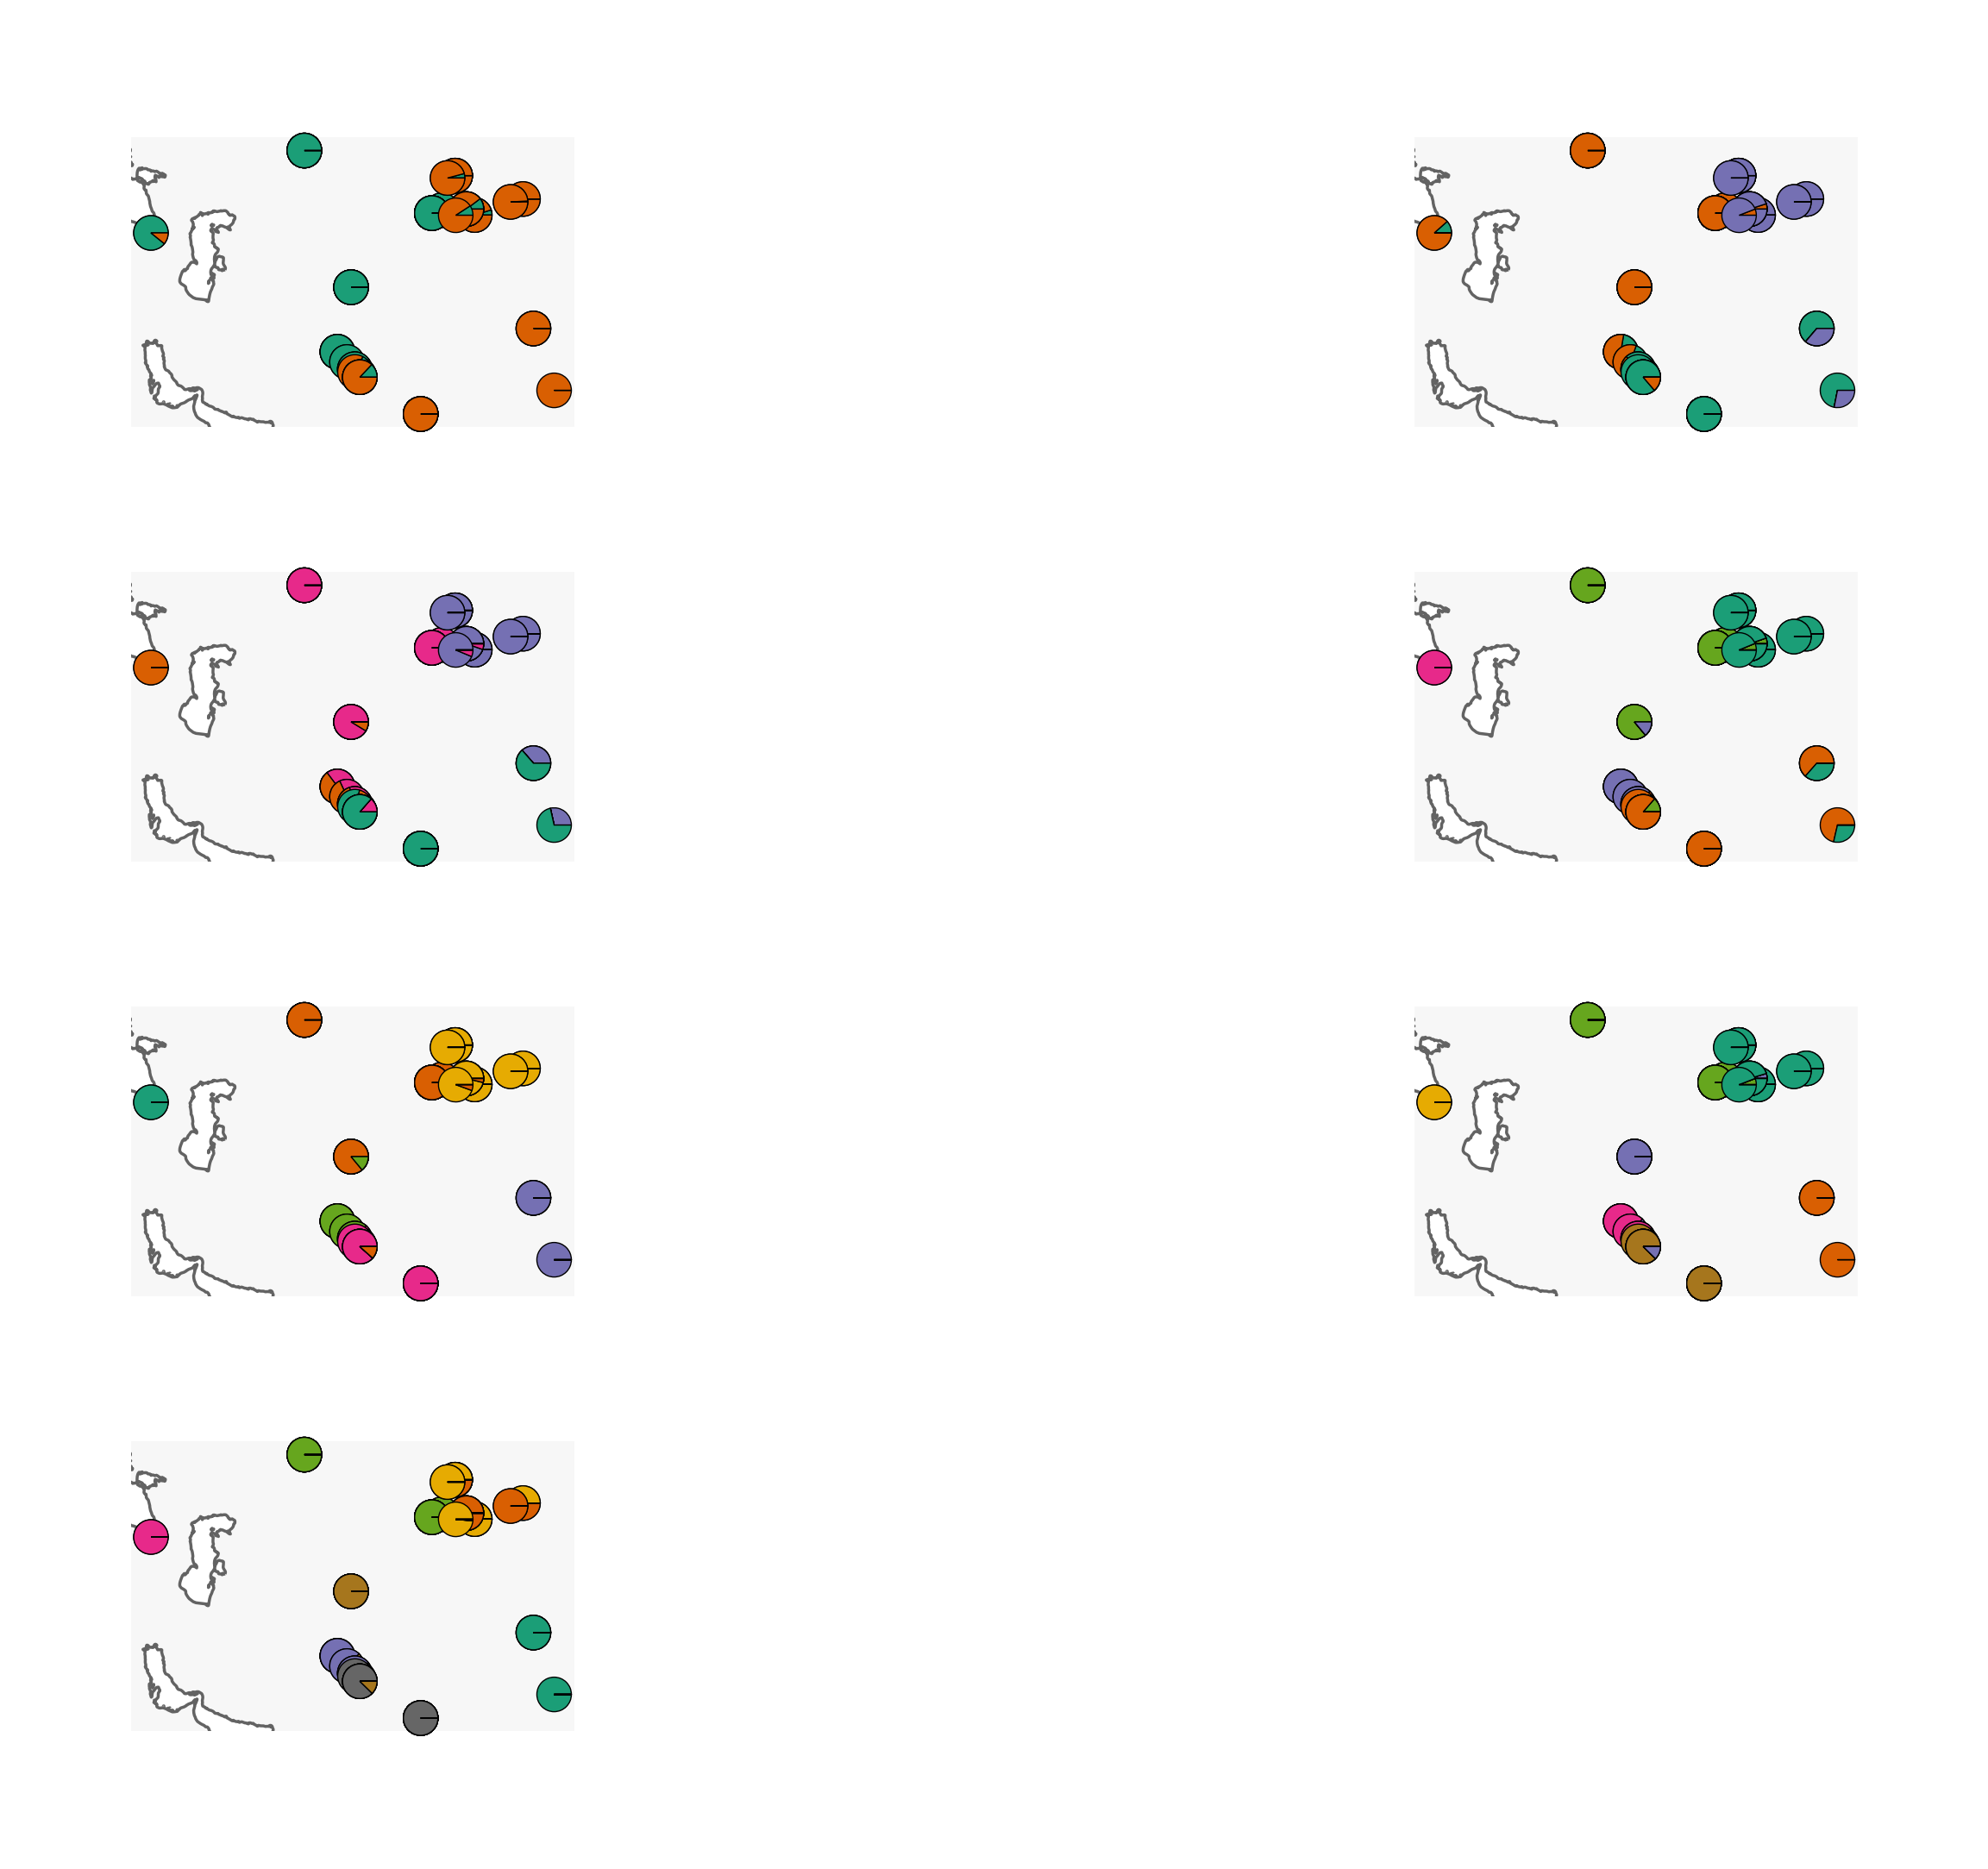

In [18]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
n, p = warblr_graph.genotypes.shape
radius = 0.2; title_pad = -10; title_loc = "left"
fig = plt.figure(dpi=500)
spec = gridspec.GridSpec(ncols=2, nrows=4, figure=fig, wspace=0.5, hspace=0.5)

#################### axis 00 ####################
ax_00 = fig.add_subplot(spec[0, 0], projection=projection)
# ax_00.set_title("K=2", loc=title_loc, pad=title_pad)
v = Viz(ax_00, warblr_graph, obj, projection=projection)
v.draw_map(latlong=False)
ax_00.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0.0)
for i in range(n):
    draw_admix_pie(Q_k2[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k2, 
                   radius=radius,
                   ax=ax_00)
    
#################### axis 01 ####################
ax_01 = fig.add_subplot(spec[0, 1], projection=projection)
# ax_01.set_title("K=3", loc=title_loc, pad=title_pad)
v = Viz(ax_01, warblr_graph,obj, projection=projection)
v.draw_map(latlong=False)
ax_01.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k3[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k3, 
                   radius=radius,
                   ax=ax_01)

#################### axis 10 ####################
ax_10 = fig.add_subplot(spec[1, 0], projection=projection)
# ax_10.set_title("K=4", loc=title_loc, pad=title_pad)
v = Viz(ax_10, warblr_graph, obj, projection=projection)
v.draw_map(latlong=False)
ax_10.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k4[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k4, 
                   radius=radius,
                   ax=ax_10)

#################### axis 11 ####################
ax_11 = fig.add_subplot(spec[1, 1], projection=projection)
# ax_11.set_title("K=5", loc=title_loc, pad=title_pad)
v = Viz(ax_11, warblr_graph, obj, projection=projection)
v.draw_map(latlong=False)
ax_11.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k5[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k5, 
                   radius=radius,
                   ax=ax_11)

#################### axis 20 ####################
ax_20 = fig.add_subplot(spec[2, 0], projection=projection)
# ax_20.set_title("K=6", loc=title_loc, pad=title_pad)
v = Viz(ax_20, warblr_graph, obj, projection=projection)
v.draw_map(latlong=False)
ax_20.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k6[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k6, 
                   radius=radius,
                   ax=ax_20)

#################### axis 21 ####################
ax_21 = fig.add_subplot(spec[2, 1], projection=projection)
# ax_21.set_title("K=7", loc=title_loc, pad=title_pad)
v = Viz(ax_21, warblr_graph, obj, projection=projection)
v.draw_map(latlong=False)
ax_21.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k7[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k7, 
                   radius=radius,
                   ax=ax_21)

#################### axis 30 ####################
ax_30 = fig.add_subplot(spec[3, 0], projection=projection)
# ax_30.set_title("K=8", loc=title_loc, pad=title_pad)
v = Viz(ax_30, warblr_graph, obj, projection=projection)
v.draw_map(latlong=False)
ax_30.scatter(v.coord[:,0], v.coord[:,1], marker=".", s=0)
for i in range(n):
    draw_admix_pie(Q_k8[i, :], 
                   v.coord[i, 0], 
                   v.coord[i, 1], 
                   colors_k8, 
                   radius=radius,
                   ax=ax_30)

In [ ]:
# genotypeswoTU = genotypes[np.concatenate((range(34),range(36,genotypes.shape[0]))),:]
# genotypeswoTU = np.delete(genotypeswoTU,np.where(genotypeswoTU.sum(axis=0)==0)[0],1)
# genotypeswoTU = np.delete(genotypeswoTU,np.where(genotypeswoTU.sum(axis=0)==2*genotypeswoTU.shape[0])[0],1)
# from feems.utils import *
# tiles = fiona.collection(grid_path)
# t = [shapely.geometry.shape(t["geometry"]) for t in tiles]
# pts, rev_pts, e = create_tile_dict([t for t in load_tiles(grid_path) if shapely.geometry.Polygon(outer).intersects(t)], shapely.geometry.Polygon(outer))
# warblr_graph.nodes[0]['pos'], warblr_graph.nodes[1]['pos'], warblr_graph.nodes[2]['pos'], warblr_graph.nodes[3]['pos'] 
# haversine_distances(math.radians(np.array([34.315, 54.836]).reshape(1,-1)),math.radians(np.array([33.512, 55.88]).reshape(1,-1)))
# plt.hist([t[i].area for i in range(len(t))])
# ?haversine_distances
# C = np.vstack((-np.ones(warblr_graph.n_observed_nodes-1),np.eye(warblr_graph.n_observed_nodes-1))).T
# tril_idx = np.tril_indices(warblr_graph.n_observed_nodes-1,-1)
# Rmat = -2*obj.Linv[:warblr_graph.n_observed_nodes,:warblr_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:warblr_graph.n_observed_nodes,:warblr_graph.n_observed_nodes]),(1,-1)).T @ np.ones((warblr_graph.n_observed_nodes,1)).T + np.ones((warblr_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Q1mat = (np.ones((warblr_graph.n_observed_nodes,1)) @ np.reshape(1/warblr_graph.q,(1,-1))).T
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/warblr_graph.q)
# plt.plot(-0.5*(C@resmat@C.T)[tril_idx],(C@warblr_graph.S@C.T)[tril_idx],'bo',alpha=0.6,); plt.axline((1.,1.),slope=1,color='grey',ls='--'); plt.xlabel(r'$-\frac{1}{2}C\Delta C^\top$'); plt.ylabel(r'$C \hat \Sigma C^\top$'); plt.plot(np.diag(-0.5*C@resmat@C.T),np.diag(C@warblr_graph.S@C.T),'ko',alpha=0.6,); plt.title('warblers dataset'); plt.grid()
# len(warblr_graph.nodes)

In [ ]:
# os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/59-Ursus_Example")
# coord = np.loadtxt("59-Ursus_FILT.coords.txt",usecols=(1,2))  # sample coordinates
# outer = np.loadtxt("california_grid.txt")  # outer coordinates
# grid_path = "world_triangle_res8.shp"  # path to discrete global grid

# (bim, fam, G) = read_plink("59-Ursus_pruned_0.6")
# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# genotypes = imp.fit_transform((np.array(G)).T)

# print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

# # graph input files
# outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
#                                              ggrid=grid_path,
#                                              translated=True, 
#                                              buffer=1,
#                                              outer=None)

# genotypes = genotypes[:,np.random.choice(genotypes.shape[1],size=200000,replace=False)]
# genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==0)[0],1)
# genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==2*genotypes.shape[0])[0],1)

In [ ]:
lamb_grid = np.geomspace(1e-4, 1e1, 10)[::-1]
cv_err = run_cv(warblr_graph, lamb_grid, factr=1e10)
mean_cv_err = np.mean(cv_err, axis=0)
# # float(lamb_grid[np.argmin(mean_cv_err)])

plt.plot(lamb_grid,mean_cv_err,'bo'); plt.axvline(float(lamb_grid[np.argmin(mean_cv_err)]),color='orange'); plt.semilogx(); plt.xlabel(r'$\lambda$'); plt.ylabel('CV error'); plt.grid()

# sp_graph = FEEMSmix_SpatialGraph(genotypes, coord, grid, edges)
# sp_graph.fit(lamb=.01, optimize_q='n-dim')

# projection = ccrs.AzimuthalEquidistant(central_longitude=-120.88, central_latitude=39.27)   
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()

# obj = FEEMSmix_Objective(sp_graph); obj.inv(); obj.Lpinv = np.linalg.pinv(obj.sp_graph.L.todense()); obj.grad(reg=False)
# tril_idx = np.tril_indices(sp_graph.n_observed_nodes, k=-1)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[tril_idx]
# emp_dist = cov_to_dist(emp_cov)[tril_idx]

# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4); plt.xlabel('Expected (fit) genetic distance'); 
# plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1) 
# plt.axline((1,1),slope=1,color='orange',ls='--',lw=2); plt.grid()
# plt.text(3.5, 1.5, r'$R^2 \approx {:.2f}$'.format(res.rsquared_adj), fontsize=15); plt.ylabel('Observed genetic distance')

# outlier_df = obj.extract_outliers(pthresh=0.001,verbose=False)

In [ ]:
# contour_df = obj.calc_contour(destpid=686, search_area='range', opts=[[-123.8,-119],[38,42.2]])

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.draw_c_contour(contour_df,levels=[0.05,0.1,0.15])

# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.draw_ll_contour(contour_df,levels=[-100,-20,-10,-2,0])
# contour_df.iloc[np.where(contour_df['scaled log-lik']>=-2)]

In [ ]:
# outlier_df
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, sp_graph, projection=projection, edge_width=.5, edge_alpha=1, edge_zorder=100, sample_pt_size=10, obs_node_textsize=5,
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1, cbar_font_size=8)
# v.draw_map(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# for i in range(len(outlier_df)):
#     v.ax.plot(
#         [v.grid[outlier_df['source'][i], 0],v.grid[outlier_df['dest.'][i],0]],
#         [v.grid[outlier_df['source'][i], 1],v.grid[outlier_df['dest.'][i],1]],
#         color = 'grey', linewidth = 1, alpha=0.6
#     )
#     v.ax.text(
#         np.mean([v.grid[outlier_df['source'][i], 0],v.grid[outlier_df['dest.'][i], 0]]),
#         np.mean([v.grid[outlier_df['source'][i], 1],v.grid[outlier_df['dest.'][i], 1]]),
#         str("{:.1f}e-4".format(outlier_df['pval'][i]*1e4)),
#         horizontalalignment="center",
#         verticalalignment="center",
#         size=v.obs_node_textsize*1.5
#     )

In [ ]:
# smgraph = SpatialGraph(genotypes, coord, grid, edges)
# smgraph.fit(lamb=1.); smgraph.s2
# smgraph.fit(lamb=.75,optimize_q='n-dim',lamb_q=.25,alpha_q=.5)

# obj = Joint_Objective(warblr_graph); obj.inv(); obj.grad(reg=False)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[np.tril_indices(warblr_graph.n_observed_nodes, k=-1)]
# emp_dist = cov_to_dist(emp_cov)[np.tril_indices(warblr_graph.n_observed_nodes, k=-1)]
# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1)
# plt.text(1, 0.3, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,2)), fontsize=15); plt.title(r'$c=0.25$'); plt.xlabel('fit distance'); plt.ylabel('empirical distance'); plt.grid();

# het_white(res.resid, X)

# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),bins=15); plt.axvline(-1.7*np.std(emp_dist/fit_dist),color='red')
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko',alpha=0.8); plt.axhline(-2.1*np.std(emp_dist/fit_dist),color='red',ls='--'); plt.axhline(0,color='grey',linewidth=2); plt.grid()
# for k in np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)< -2 * np.std(emp_dist/fit_dist))[0]:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)

# sp.stats.norm.ppf(0.01)

# np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist) < -2 * np.std(emp_dist/fit_dist))[0]
# pvals = sp.stats.norm.cdf((emp_dist/fit_dist-np.mean(emp_dist/fit_dist)), 0, np.std(emp_dist/fit_dist))
# np.where(pvals < 0.01)[0]

# idx = np.random.choice(genotypes.shape[1],size=1500,replace=False)
# bootgenotypes = genotypes[:,idx]
# bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
# bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
# warblr_graph = Joint_SpatialGraph(genotypes, coord, grid, edges)
# warblr_graph.fit(lamb=.5,optimize_q='n-dim',lamb_q=1.,alpha_q=0.1)

In [ ]:
# projection = ccrs.AzimuthalEquidistant(central_longitude=85.5, central_latitude=42.54)   
# fig = plt.figure(dpi=200)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1,
#         cbar_font_size=8)
# v.ax.set_extent([45,130,19,60], crs=ccrs.PlateCarree())
# v.draw_map(); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); #v.draw_edge_colorbar()

In [ ]:
# lle, te = get_best_lre(warblr_graph, lamb_cv=0.1, k=5, top=10, nchoose=100, option='hard')

# warblr_graph.fit(lamb=1.,optimize_q=None)
# obj = FEEMSmix_Objective(warblr_graph); obj.inv(); obj.Lpinv = np.linalg.pinv(obj.sp_graph.L.todense()); obj.grad(reg=False)
# outliers_df = obj.extract_outliers(pthresh=0.01, verbose=True)
# warblr_graph.s2
# warblr_graph.nodes[88]

# contour_df = obj.calc_contour(destpid=193, search_area='radius', sourcepid=88, opts=2)
# contour_df

# [v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge]

# plt.scatter(wn,warblr_graph.w,alpha=0.5); plt.grid(); plt.axline((1,1),slope=1)

# warblr_graph.fit(lamb=10.5,optimize_q='n-dim',lamb_q=1.,alpha_q=0.5,option='onlyc',long_range_edges=[(2,15),(13,16),(7,18),(0,10)])
# warblr_graph.c 
# obj = Joint_Objective(warblr_graph); obj.inv(); obj.grad(reg=False)
# obj.Linv.shape

In [ ]:
# contour_df.iloc[contour_df['scaled log-lik'].argmax(),0]
[v.grid[x[0],0] for x in contour_df['(source, dest.)']]

In [ ]:
def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)       

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn, Lpinv):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)      

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

In [ ]:
# obj.Linv.shape
# af = genotypes.sum(axis=0)/(2*95)
# plt.hist(af,bins=20); plt.xlabel('allele frequency'); 
# plt.plot(2*af*(1-af),'ko',alpha=0.4); plt.grid()

# TU: 34, 35 & AB: 8, 9 (~60% of sites are invariant between the two)
# p1 = genotypes[34:36,:].sum(axis=0)/(2*2)
# p2 = genotypes[76:78,:].sum(axis=0)/(2*2)

# fst = (p1*(1-p2-1+p1) + p2*(1-p1-1+p2))/(p1*(1-p2)+p2*(1-p1))
## fst[np.isnan(fst)] = 0
# plt.plot(fst[~np.isnan(fst)],'k-o',alpha=0.3); plt.grid(); plt.ylabel(r'$F_{ST}$'); plt.xlabel('SNP index')
# nx.get_node_attributes(warblr_graph,'permuted_idx')
# Lpinv = sp.sparse.linalg.pinv(warblr_graph.L); 
# obj = Joint_Objective(warblr_graph); obj.inv(); obj.grad(reg=False)

In [ ]:
# randedge = [(x,14) for x in list(set(range(1000))-set([14]))]
## only pick non-edge demes to avoid boundary issues 
# randedge = list(it.compress(randedge,np.array([sum(1 for _ in warblr_graph.neighbors(nx.get_node_attributes(warblr_graph,'permuted_idx')[i])) for i in list(set(range(1200))-set([14]))])==6))
# randedge = [(x,15) for x in [list(nx.get_node_attributes(warblr_graph, 'permuted_idx').values()).index(n) for n in np.unique(neighs)]] 
# isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
# randedge, isc2, llc2 = calc_contour(obj, destpid=1072, sourcepid=88, coverage='radius', radius=5)
# for ie, e in enumerate(randedge):
#     if e[0]<18:
#         res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(warblr_graph, obj, [e]), bounds=(0,1), method='bounded')
#         isc2[ie] = res.x; llc2[ie] = res.fun
#     else:
#         try:
#             res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(warblr_graph, obj, [e], Lpinv), bounds=(0,1), method='bounded')
#         except:
#             continue
#         isc2[ie] = res.x; llc2[ie] = res.fun

In [ ]:
# sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(warblr_graph, objf, [(555,15)], Lpinv), bounds=(0,1), method='bounded')
# isc2[llc2-20<np.min(llc2)]
# warblr_graph.w.shape,len(list(warblr_graph.edges))
# Lpinv = np.linalg.pinv(warblr_graph.L.todense());
# fac = cholmod.cholesky(sp.sparse.csc_matrix(warblr_graph.L_block['dd']+np.ones((1571,1571))/1589))
plt.scatter(np.diag(Lpinv)[18:],np.linalg.norm(fac.solve_L(np.diag(np.repeat(1,1571)),use_LDLt_decomposition=False),axis=0)**2); plt.axline((0.2,0.2),(1,1)); plt.grid()
# plt.plot(np.linalg.norm(fac.solve_L(np.diag(np.repeat(1,1571)),use_LDLt_decomposition=False),axis=0)**2)

In [ ]:
permuted_idx = query_node_attributes(warblr_graph, "permuted_idx")
# obs_perm_ids = permuted_idx[: warblr_graph.n_observed_nodes]
# node_to_pop = pd.DataFrame(index = np.arange(warblr_graph.n_observed_nodes), columns = ['nodes', 'pops'])
# node_to_pop['nodes'] = obs_perm_ids

# max_res_nodes = [(2,15)] #[(1,9),(2,15),(16,13),(0,10)] #[(10,1),(2,15),(0,13),(7,18)]
# [(255, 1060), (484, 1195), (1224, 1146), (12, 1092)] #[(1092, 255), (484, 1195), (12, 1146), (1264, 700)]
# list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)].values.reshape(1,2)))

# C = np.vstack((-np.ones(warblr_graph.n_observed_nodes-1),np.eye(warblr_graph.n_observed_nodes-1))).T
# bootgenotypesc = genotypes[:,list(set(range(2247))-set(idx))]
# bootgenotypesc = np.delete(bootgenotypesc,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
# bootgenotypesc = np.delete(bootgenotypesc,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
# warblr_graphc = Joint_SpatialGraph(bootgenotypesc, coord, grid, edges)
# warblr_graphc.fit(lamb=1.,optimize_q='n-dim',lamb_q=1.,alpha_q=0.5)
# obj = Joint_Objective(warblr_graphc); obj.inv(); obj.grad(reg=False);
# Rmat = -2*obj.Linv[:19,:19] + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((warblr_graphc.n_observed_nodes,1)).T + np.ones((warblr_graphc.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Q1mat = (np.ones((warblr_graphc.n_observed_nodes,1)) @ np.reshape(1/warblr_graphc.q,(1,-1))).T
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/warblr_graphc.q)
# llnull = sp.stats.wishart.logpdf(2*C @ warblr_graphc.S @ C.T, warblr_graphc.n_snps, -0.5/warblr_graphc.n_snps*C @ resmat @ C.T)

# warblr_graph.fit(lamb=1.,optimize_q='n-dim',lamb_q=1.,alpha_q=0.5, option='onlyc', long_range_edges=[(1,9)])
# warblr_graph.c # array([0.46752871, 0.1849542 , 0.42977615, 0.38951518]) # array([0.08894425, 0.25479647, 0.12617096, 0.05590574])
# objc = Joint_Objective(warblr_graphc); objc.inv(); objc.grad(reg=False); print(sp.stats.chi2.sf(-2*(llnull+objc.neg_log_lik_c(warblr_graphc.c)),2))
# [list(warblr_graph.neighbors(n1)) for n1 in list(warblr_graph.neighbors(n)) for n in list(warblr_graph.neighbors(484))]
# neighs = [] 
# for n in list(warblr_graph.neighbors(484)):
#     n1 = list(warblr_graph.neighbors(n))
#     for n2 in n1:
#         n3 = list(warblr_graph.neighbors(n2))
#         for n4 in n3:
#             n5 = list(warblr_graph.neighbors(n4))
#             for n6 in n5:
#                 neighs.append(list(warblr_graph.neighbors(n6)))

# neighs = []
# neighs = list(warblr_graph.neighbors(484))
# for r in range(7):
#     tempn = [list(warblr_graph.neighbors(n1)) for n1 in neighs]
#     neighs = np.unique(list(it.chain(*tempn)))
# permuted_idx[randedge[np.argmin(llc2)][0]], permuted_idx[14], isc2[np.where(llc2-2<np.min(llc2)+2)[0]]
# np.where(llc2-2<np.min(llc2))

In [ ]:
# np.unique(neighs)
# [warblr_graph.neighbors(nn) for nn in n]
# np.ravel([list(warblr_graph.neighbors(n1)) for n1 in n])
# sprange = [[60,80],[20,40]]
# randedge = []
# for n in range(warblr_graph.number_of_nodes()):
#     if warblr_graph.nodes[n]['pos'][0] > sprange[0][0] and warblr_graph.nodes[n]['pos'][0] < sprange[0][1]:
#                 if warblr_graph.nodes[n]['pos'][1] > sprange[1][0] and warblr_graph.nodes[n]['pos'][1] < sprange[1][1]:
#                     randedge.append((n,14))

In [ ]:
nx.get_node_attributes(obj.sp_graph,'permuted_idx')[randedge[np.argmin(llc2)][0]]

In [ ]:
# fig = plt.figure(dpi=180)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
#         cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
# v.draw_map(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,extend='min',cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
# CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',extend='min',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')

## basically ignore demes with log-lik units less than 100 of max
# fig = plt.figure(dpi=180)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
#         cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
# v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
# v.draw_map(); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.ax.gridlines(draw_labels=False,ylocs=[20.5,40],xlocs=[40,60,80,100,120,140],linewidth=0.3,color='grey',linestyle='-',zorder=0,alpha=0.6)
# v.ax.gridlines(draw_labels=False,ylocs=[66.5],xlocs=[],linewidth=0.3,color='grey',linestyle=(5, (10, 3)),zorder=0,alpha=0.6)
# # for ie, e in enumerate([(2,15)]):#[(255, 1060), (484, 1195), (1224, 1146), (12, 1092)]):
# #         v.draw_arrow([e],warblr_graph.c[ie],lw=1,hw=.5e5,hl=1e5,mode='sampled')
# # v.draw_c_colorbar()
# ax.tricontourf([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],isc2[llc2-20<np.min(llc2)],vmin=0,vmax=1,levels=3,cmap='Greys',alpha=0.7); CS = ax.tricontour([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],isc2[llc2-20<np.min(llc2)],vmin=0,vmax=1,levels=3,cmap='Greys',alpha=0.7); ax.clabel(CS, inline=1, fontsize=5, colors='k')
# ax.scatter(vsm.grid[1195,0],vsm.grid[1195,1],marker='x',color='k',zorder=2); ax.scatter(vsm.grid[255,0],vsm.grid[255,1],marker='*',facecolors='none',edgecolors='k');


# fig = plt.figure(dpi=180)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
#         cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
# v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
# v.draw_map(latlong=True); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.draw_c_contour(contour_df, levels=3, fs=6)

# fig = plt.figure(dpi=180)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, smgraph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
#         cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
# v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
# v.draw_map(latlong=True); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.draw_ll_contour(contour_df)
# v.ax.gridlines(draw_labels=True,ylocs=[20.5,40],xlocs=[40,60,80,100,120,140],linewidth=0.3,color='grey',linestyle='-',zorder=0,alpha=0.6)
# v.ax.gridlines(draw_labels=True,ylocs=[66.5],xlocs=[],linewidth=0.3,color='grey',linestyle=(5, (10, 3)),zorder=0,alpha=0.6)
# ax.tricontourf([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=5, colors='k'); 
# # # for (15) -> (273,1195), (9) -> (362,1060), (10) -> () ## permuted_idx[15]
# # ax.scatter(vsm.grid[,0],vsm.grid[1060,1],marker='x',color='k',zorder=2); ax.scatter(vsm.grid[362,0],vsm.grid[362,1],marker='*',zorder=2,facecolors='none',edgecolors='k');
# ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=5, colors='k'); 
# for (15) -> (273,1195), (9) -> (362,1060), (10) -> () ## permuted_idx[15]
# ax.scatter(v.grid[1007,0],v.grid[1007,1],marker='x',color='k',zorder=2); ax.scatter(v.grid[971,0],v.grid[971,1],marker='*',zorder=2,facecolors='none',edgecolors='k');

In [ ]:
sample_idx = nx.get_node_attributes(warblr_graph, "sample_idx")
permuted_idx = query_node_attributes(warblr_graph, "permuted_idx")
observed_permuted_idx = permuted_idx[: warblr_graph.n_observed_nodes]

freqs = np.zeros_like(warblr_graph.frequencies)
for i, node_id in enumerate(observed_permuted_idx):
    s = sample_idx[node_id]

    # compute mean at each node
    freqs[i,:] = np.mean(warblr_graph.genotypes[s,:], axis=0)/2

het = 2*freqs*(1-freqs)

plt.plot(np.arange(1,warblr_graph.n_observed_nodes+1),het.mean(axis=1),'ko'); plt.axhline(het.mean(),color='red',linestyle='--'); plt.xlabel('deme ID'); plt.ylabel('average heterozygosity'); plt.grid()

In [ ]:
# lamb_grid = np.geomspace(1e-2, 1e2, 10)[::-1]
# cv10_err = run_cv_joint(warblr_graph, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid, n_folds=10)
# plt.plot(lamb_grid,np.nanmean(cv10_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('10-fold CV error'); plt.plot(lamb_grid,np.nanmean(cv10_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 

smgraph.fit(lamb=0.001,optimize_q='n-dim',lamb_q=.001,alpha_q=0.01/np.mean(smgraph.s2))
obj = Joint_Objective(smgraph); obj.inv(); obj.grad(reg=False)
tril_idx = np.tril_indices(warblr_graph.n_observed_nodes, k=-1)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4); plt.xlabel('Expected (fit) genetic distance'); 
# plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1) 
plt.axline((0,0),slope=1,color='orange',ls='--',lw=2); plt.grid()
# plt.text(3.5, 0.5, r'$R^2 \approx {:.2f}$'.format(res.rsquared_adj), fontsize=15); plt.ylabel('Observed genetic distance')